In [1]:
cd -q ~/TaskSCCA_craddock/

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np

from nilearn.plotting import cm

import pandas as pd

from sklearn.model_selection import ParameterGrid, KFold, train_test_split

# retrieve data
# define global variables
from src.pypma import SCCA
from src.visualize import set_text_size, write_pdf
from src.utils import unflatten, save_pkl

In [3]:
X_clean = np.load('data/processed/X_clean.npy')
Y_clean = np.load('data/processed/Y_clean.npy')

# Parameter selection

In [4]:
def sparse_parameter_selection(X, Y, n_fold, seed=1):
    '''
    Combine grid search and cross-validation for sparse parameter selection
    '''
    # find the best parameter on the first canonical variate
    # find the smallest p_FDR
    param_grid = {'C_x': np.array(range(1, 11)) * 0.1,
                    'C_y': np.array(range(1, 11)) * 0.1}

    param_grid = ParameterGrid(param_grid)

    # set random seed
    np.random.seed(seed)
    resample = n_fold
    # cross-validation on the disocery set to get the penalties
    para_search = np.zeros((10, 10))

    for j, parameters in enumerate(iter(param_grid)):

        para_idx = np.unravel_index(j, para_search.shape) # (C_x,C_y)
        model = SCCA(C=[parameters['C_x'], parameters['C_y']],
                        penalty=['l1', 'l1'],n_component=1, verbose=False)
        dj_best = 0
        kf = KFold(n_splits=resample, shuffle=True)
        for i, (train_index, test_index) in enumerate(kf.split(X_clean)):
            X_train, X_test = X_clean[train_index, :], X_clean[test_index, :]
            Y_train, Y_test = Y_clean[train_index, :], Y_clean[test_index, :]

            model.fit(X_train, Y_train)
            d_j = model.score(X_test, Y_test)

            if d_j > para_search[para_idx]:
                para_search[para_idx] = d_j
                
    d_sig = np.max(para_search)
    d_idx = np.argwhere(para_search == d_sig)
    C = 0.1 * (d_idx + 1)[0]
    print('Best parameters based on cross-validation:', C)
    print('Canonical correlation:', d_sig)
    
    return para_search, C

In [5]:
# plotting
def plot_parameter_search(para_search, x_lab, y_lab, fig_name):
    
    title = 'Sparsity Parameter Search'

    set_text_size(12)

    fig,ax = plt.subplots()
    hm = ax.imshow(para_search.T, vmin=para_search.min(), vmax=para_search.max())
    plt.xticks(range(10), np.around(np.array(range(1, 11)) * 0.1, decimals=1))
    plt.yticks(range(10), np.around(np.array(range(1, 11)) * 0.1, decimals=1))
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)
    plt.colorbar(hm, label='Canonical Correlation')
    # Create a Rectangle patch

    d_sig = np.max(para_search)
    d_idx = np.argwhere(para_search == d_sig)
    rect = patches.Rectangle(d_idx[0] - 0.5, 1, 1,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.savefig(fig_name, dpi=300)
    plt.show()
    plt.close()

In [6]:
para_search, C = sparse_parameter_selection(X_clean, Y_clean, n_fold=5, seed=1)

Best parameters based on cross-validation: [0.4 0.6]
Canonical correlation: 0.5163762374335092


/home/hw1012/TaskSCCA_craddock/env/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/hw1012/TaskSCCA_craddock/env/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


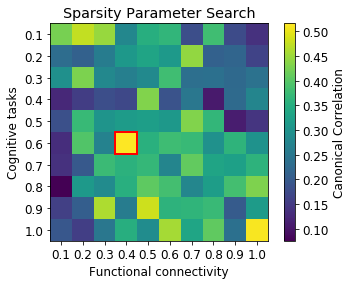

In [7]:
plot_parameter_search(para_search, 'Functional connectivity', 'Cognitive tasks', 'reports/figures/parameter_search.png')

In [8]:
# fit the real model here
n_mod = 13
model = SCCA(C=C, penalty=['l1', 'l1'],
        n_component=n_mod, verbose=False)

model.fit(X_clean, Y_clean)
u, v, d = model.u, model.v, model._cancorr

In [9]:
# find the best mode
# by calculating the FWE-corrected p-value based on false discovery rate
permute = 1000
alpha = 0.05

permD = np.zeros((permute, n_mod))
permU = np.zeros((permute, u.shape[0], n_mod))
permV = np.zeros((permute, v.shape[0], n_mod))
for i in range(permute):
    per_idx = np.random.permutation(Y_clean.shape[0])
    cur_y = Y_clean[per_idx, :]
    perm_model = SCCA(C=C, penalty=['l1', 'l1'], n_component=n_mod, verbose=False)
    perm_model.fit(X_clean, cur_y)
    perm_d = perm_model._cancorr
    permD[i, :] = perm_d

# calculate the FWE-corrected p value
p_j = (1 + np.sum(d < np.repeat(permD[1:, 0:1], n_mod, axis=1),0)) / float(permute)
sig = p_j < alpha
print('discovery p fdr: ', p_j)
print('discovery sig: ', sig)

discovery p fdr:  [0.085 0.293 0.336 0.559 0.456 0.755 0.036 0.368 0.565 0.117 0.011 0.832
 0.803]
discovery sig:  [False False False False False False  True False False False  True False
 False]


In [10]:
# select the significant ones for this parameter set
# sig_mod = {'can_corr': d[sig],
#             'u'       : u[:, sig],
#             'v'       : v[:, sig],
#             'p_val'   : p_j[sig],
#             'sig'     : sig
#           }

# save_pkl(sig_mod, 'models/sig_95th.pkl')
# save_pkl(model, 'models/full_model_95th.pkl')